In [45]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout

from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image

### Building the DeepID2 model

In [12]:
def deepID_2(input_shape=None):
    input_data = Input(shape=input_shape)
    # First convolution block
    conv1 = Conv2D(20, (4, 4), name='Conv1', activation='relu')(input_data)
    maxpool1 = MaxPooling2D(pool_size=2, strides = 2, name='MaxPool1')(conv1)
    drop1 = Dropout(rate=0.5, name='Dropout1')(maxpool1)
    # Second convolution block
    conv2 = Conv2D(40, (3, 3), name='Conv2', activation='relu')(drop1)
    maxpool2 = MaxPooling2D(pool_size=2, strides = 2, name='MaxPool2')(conv2)
    drop2 = Dropout(rate=0.5, name='Dropout2')(maxpool2)
    #Third convolution block
    conv3 = Conv2D(60, (3, 3), name='Conv3', activation='relu')(drop2)
    maxpool3 = MaxPooling2D(pool_size=2, strides = 2, name='MaxPool3')(conv3)
    drop3 = Dropout(rate=0.5, name='Dropout3')(maxpool3)
    
    # First route
    x1 = Flatten()(drop3)
    fc_1 = Dense(160, name='FC_1')(x1)
    
    # Second route
    x2 = Conv2D(80, (2, 2), name='Conv4', activation='relu')(drop3)
    x2 = Flatten()(x2)
    fc_2 = Dense(160, name = 'FC_2')(x2)
    
    # Add
    y = Add()([fc_1, fc_2])
    output = Activation('relu', name='DeepID2')(y)
    model = Model(inputs=input_data, outputs=output)
    return model
    

In [13]:
input_shape = (55, 47, 3)
model = deepID_2(input_shape=input_shape)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 52, 44, 20)   980         input_4[0][0]                    
__________________________________________________________________________________________________
MaxPool1 (MaxPooling2D)         (None, 26, 22, 20)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Dropout1 (Dropout)              (None, 26, 22, 20)   0           MaxPool1[0][0]                   
______________________________________________________________________________________________

#### Loading pretrained weights

In [15]:
model.load_weights('./weights/deepid_weights.h5')

#### Image preroccessing

In [18]:
# initializing th classifiers
cascPath=os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

In [98]:
def detect_face(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    faces = faceCascade.detectMultiScale(img, 1.3, 5)
    
    if len(faces) > 0:
        x,y,w,h = faces[0]
        
        margin = 0
        x_margin = w * margin / 100
        y_margin = h * margin / 100
        
        if y - y_margin > 0 and y+h+y_margin < img.shape[1] and x-x_margin > 0 and x+w+x_margin < img.shape[0]:
            detected_face = img[int(y-y_margin):int(y+h+y_margin), int(x-x_margin):int(x+w+x_margin)]
        else:
            detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        
        detected_face = cv2.resize(detected_face, target_size)
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        #normalize in [0, 1]
        img_pixels /= 255 
        
        return img_pixels
    else:
        raise ValueError("Face could not be detected in ", img_path,". Please confirm that the picture is a face photo.")

#### Distance Metrics

In [99]:
def findCosineDistance(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))	


#### Evaluation

In [100]:
target_size_x = model.layers[0].input_shape[0][1]
target_size_y = model.layers[0].input_shape[0][2]
print("model input shape is (",target_size_x," x ",target_size_y,")")

model input shape is ( 55  x  47 )


In [101]:
idendities = {
    "Angelina": ["img2.jpg", "img4.jpg", "img6.jpg"],
    "Katy": ["img42.jpg", "img44.jpg", "img45.jpg"],
    "Scarlett": ["img9.jpg", "img48.jpg", "img49.jpg"],
}

In [42]:
positives = []
for key, values in idendities.items():
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)


positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

In [46]:
samples_list = list(idendities.values())
negatives = []
for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        
        for cross_sample in cross_product:
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)
            
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

In [48]:
negatives = negatives.sample(positives.shape[0], random_state=17)

In [50]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [52]:
df.shape

(18, 3)

In [53]:
df.decision.value_counts()

Yes    9
No     9
Name: decision, dtype: int64

In [54]:
df.file_x = "../DeepFace/test/fine_tune/"+df.file_x
df.file_y = "../DeepFace/test/fine_tune/"+df.file_y

In [55]:
df.head()

,file_x,file_y,decision
0,../DeepFace/test/fine_tune/img2.jpg,../DeepFace/test/fine_tune/img4.jpg,Yes
1,../DeepFace/test/fine_tune/img2.jpg,../DeepFace/test/fine_tune/img6.jpg,Yes
2,../DeepFace/test/fine_tune/img4.jpg,../DeepFace/test/fine_tune/img6.jpg,Yes
3,../DeepFace/test/fine_tune/img42.jpg,../DeepFace/test/fine_tune/img44.jpg,Yes
4,../DeepFace/test/fine_tune/img42.jpg,../DeepFace/test/fine_tune/img45.jpg,Yes


In [56]:
metrics = ["cosine", "euclidean", "euclidean_l2"]
for metric in metrics:
    df["DeepID_%s" % (metric)] = 0

In [64]:
for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
    img1_path = instance["file_x"]
    img2_path = instance["file_y"]
    
    img1 = detect_face(img1_path, (target_size_y, target_size_x))
    img2 =  detect_face(img2_path, (target_size_y, target_size_x))
    
    img1_representation = model.predict(img1)[0,:]
    img2_representation = model.predict(img2)[0,:]
    
    for j in metrics:
        if j == 'cosine':
            distance = findCosineDistance(img1_representation, img2_representation)
        elif j == 'euclidean':
            distance = findEuclideanDistance(img1_representation, img2_representation)
        elif j == 'euclidean_l2':
            distance = findCosineDistance(l2_normalize(img1_representation), l2_normalize(img2_representation))
        
        df.loc[index, 'DeepID_%s' % (j)] = distance

100%|██████████| 18/18 [00:11<00:00,  1.55it/s]


In [65]:
df

,file_x,file_y,decision,DeepID_cosine,DeepID_euclidean,DeepID_euclidean_l2
0,../DeepFace/test/fine_tune/img2.jpg,../DeepFace/test/fine_tune/img4.jpg,Yes,0.013251,43.622673,0.013251
1,../DeepFace/test/fine_tune/img2.jpg,../DeepFace/test/fine_tune/img6.jpg,Yes,0.007995,33.976994,0.007995
2,../DeepFace/test/fine_tune/img4.jpg,../DeepFace/test/fine_tune/img6.jpg,Yes,0.023027,57.071373,0.023027
3,../DeepFace/test/fine_tune/img42.jpg,../DeepFace/test/fine_tune/img44.jpg,Yes,0.008584,42.459904,0.008584
4,../DeepFace/test/fine_tune/img42.jpg,../DeepFace/test/fine_tune/img45.jpg,Yes,0.012579,38.406708,0.012579
5,../DeepFace/test/fine_tune/img44.jpg,../DeepFace/test/fine_tune/img45.jpg,Yes,0.019250,50.620094,0.019250
6,../DeepFace/test/fine_tune/img9.jpg,../DeepFace/test/fine_tune/img48.jpg,Yes,0.015545,44.850208,0.015545
7,../DeepFace/test/fine_tune/img9.jpg,../DeepFace/test/fine_tune/img49.jpg,Yes,0.007194,37.143684,0.007194
8,../DeepFace/test/fine_tune/img48.jpg,../DeepFace/test/fine_tune/img49.jpg,Yes,0.009721,40.186909,0.009721
9,../DeepFace/test/fine_tune/img45.jpg,../DeepFace/test/fine_tune/img48.jpg,No,0.028334,61.641422,0.028334


cosine


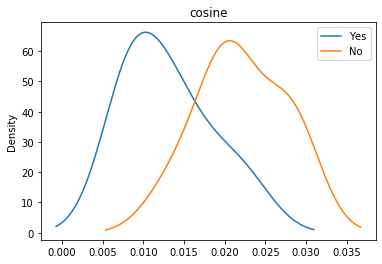

euclidean


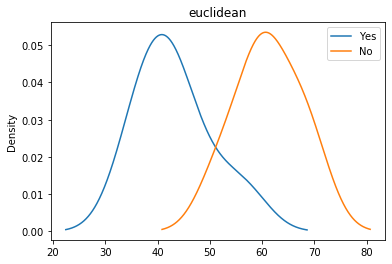

euclidean_l2


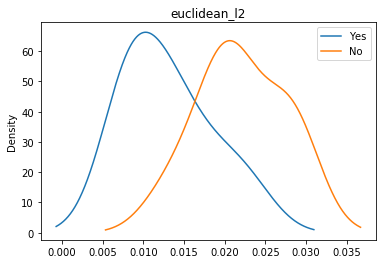

In [66]:
for metric in metrics:
    print(metric)
    df[df.decision == "Yes"]['DeepID_%s' % (metric)].plot(kind='kde', title = metric, label = 'Yes', legend = True)
    df[df.decision == "No"]['DeepID_%s' % (metric)].plot(kind='kde', title = metric, label = 'No', legend = True)
    plt.show()

In [67]:
df.head()

,file_x,file_y,decision,DeepID_cosine,DeepID_euclidean,DeepID_euclidean_l2
0,../DeepFace/test/fine_tune/img2.jpg,../DeepFace/test/fine_tune/img4.jpg,Yes,0.013251,43.622673,0.013251
1,../DeepFace/test/fine_tune/img2.jpg,../DeepFace/test/fine_tune/img6.jpg,Yes,0.007995,33.976994,0.007995
2,../DeepFace/test/fine_tune/img4.jpg,../DeepFace/test/fine_tune/img6.jpg,Yes,0.023027,57.071373,0.023027
3,../DeepFace/test/fine_tune/img42.jpg,../DeepFace/test/fine_tune/img44.jpg,Yes,0.008584,42.459904,0.008584
4,../DeepFace/test/fine_tune/img42.jpg,../DeepFace/test/fine_tune/img45.jpg,Yes,0.012579,38.406708,0.012579


In [68]:
def showInstance(idx):
    fig = plt.figure(figsize=(10,3))

    ax1 = fig.add_subplot(1,3,1)
    plt.imshow(detect_face(df.iloc[idx].file_x, (224, 224))[0][:,:,::-1])
    plt.axis('off')

    ax2 = fig.add_subplot(1,3,2)
    plt.imshow(detect_face(df.iloc[idx].file_y, (224, 224))[0][:,:,::-1])
    plt.axis('off')

    ax3 = fig.add_subplot(1,3,3)
    plt.text(0, 0.6, "Cosine: %s" % (round(df.iloc[idx].DeepID_cosine,4)))
    plt.text(0, 0.5, "Euclidean: %s" % (round(df.iloc[idx].DeepID_euclidean,4)))
    plt.text(0, 0.4, "Euclidean L2: %s" % (round(df.iloc[idx].DeepID_euclidean_l2,4)))
    plt.axis('off')

    plt.show()

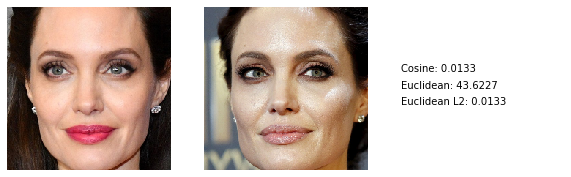

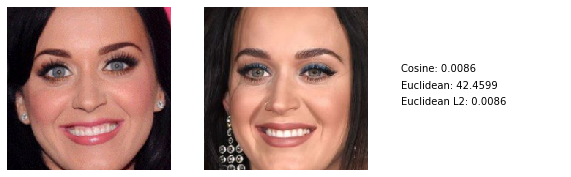

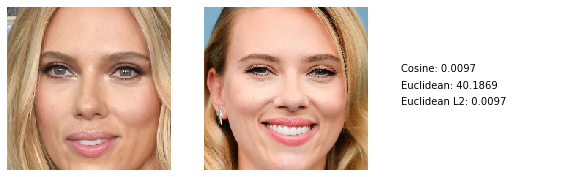

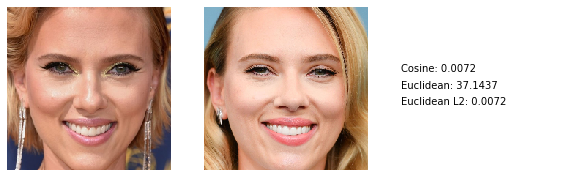

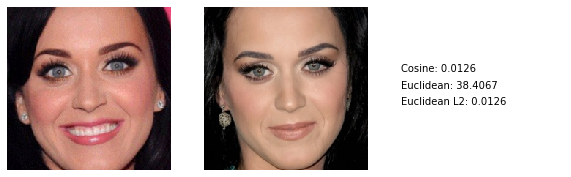

In [69]:
for i in df[df.decision == 'Yes'].sample(5, random_state=666).index.tolist():
    showInstance(i)

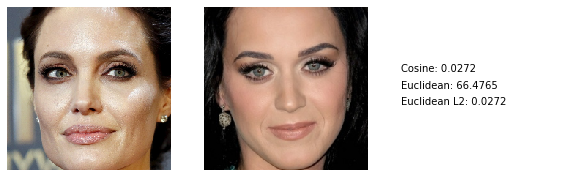

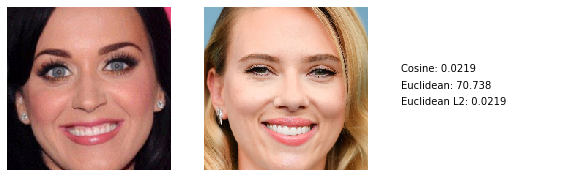

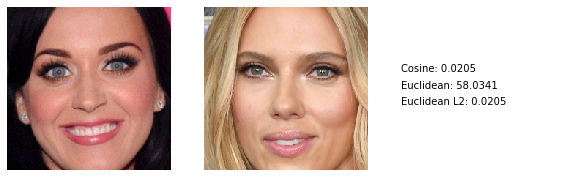

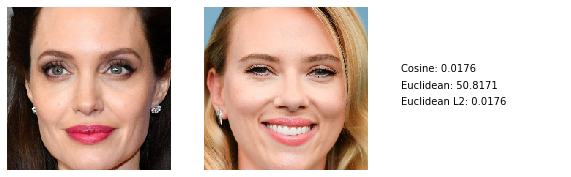

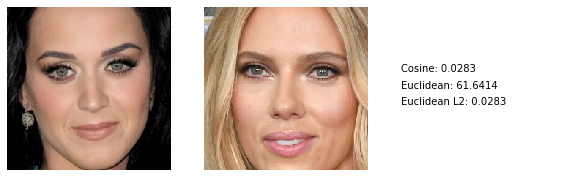

In [70]:
for i in df[df.decision == 'No'].sample(5, random_state=17).index.tolist():
    showInstance(i)

In [74]:
print("Cosine: ")
threshold = 0.017

print("actual values of verified ones: ",df[df['DeepID_cosine'] <= threshold].decision.values)
print("actual values of unverified ones: ",df[df['DeepID_cosine'] > threshold].decision.values)

print("------------------------")

print("Euclidean:")
threshold = 46

print("actual values of verified ones: ",df[df['DeepID_euclidean'] <= threshold].decision.values)
print("actual values of unverified ones: ",df[df['DeepID_euclidean'] > threshold].decision.values)

print("------------------------")

print("Euclidean L2:")
threshold = 0.017

print("actual values of verified ones: ",df[df['DeepID_euclidean_l2'] <= threshold].decision.values)
print("actual values of unverified ones: ",df[df['DeepID_euclidean_l2'] > threshold].decision.values)

Cosine: 
actual values of verified ones:  ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No']
actual values of unverified ones:  ['Yes' 'Yes' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No']
------------------------
Euclidean:
actual values of verified ones:  ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes']
actual values of unverified ones:  ['Yes' 'Yes' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No']
------------------------
Euclidean L2:
actual values of verified ones:  ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No']
actual values of unverified ones:  ['Yes' 'Yes' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No']


In [123]:
img1 = './test/nicky1.jpg'
img2 = './test/rdj1.jpg'

In [124]:
img1 = detect_face(img1, (target_size_y, target_size_x))
img2 =  detect_face(img2, (target_size_y, target_size_x))

img1_representation = model.predict(img1)[0]
img2_representation = model.predict(img2)[0]

cosine_distance = findCosineDistance(img1_representation, img2_representation)
euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
l2_distance = findCosineDistance(l2_normalize(img1_representation), l2_normalize(img2_representation))

euclidean_distance

67.709045

In [129]:
if euclidean_distance <= 45:
    verified=True
else:
    verified=False

In [130]:
print(verified)

False
